https://data.mendeley.com/datasets/y78ty2g293/1

In [50]:
%pip install --upgrade pandas numpy matplotlib seaborn scikit-learn xgboost shap boruta -q

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Libraries & global settings
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, RocCurveDisplay, precision_recall_curve, 
                             average_precision_score, roc_auc_score)

import shap
from itertools import cycle

# Set global styles and configurations
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [3]:
#DATA LOADING, CLEANING, AND SPLITTING
df = pd.read_csv('data/WQD.csv')
print("DATA BEFORE CLEANING")
print("Original Column Names:", df.columns.tolist())
display(df.head())

def clean_col_names(df_to_clean):
    new_cols = []
    for col in df_to_clean.columns:
        clean_col = col.replace('`', '').strip()
        clean_col = re.sub(r'\s*\([^)]*\)', '', clean_col)
        clean_col = re.sub(r'[\s/]+', '_', clean_col)
        new_cols.append(clean_col)
    df_to_clean.columns = new_cols
    return df_to_clean

df = clean_col_names(df)
print("\nDATA AFTER CLEANING")
print("New Column Names:", df.columns.tolist())
display(df.head())


DATA BEFORE CLEANING
Original Column Names: ['Temp', 'Turbidity (cm)', 'DO(mg/L)', 'BOD (mg/L)', 'CO2', 'pH`', 'Alkalinity (mg L-1 )', 'Hardness (mg L-1 )', 'Calcium (mg L-1 )', 'Ammonia (mg L-1 )', 'Nitrite (mg L-1 )', 'Phosphorus (mg L-1 )', 'H2S (mg L-1 )', 'Plankton (No. L-1)', 'Water Quality']


,Temp,Turbidity (cm),DO(mg/L),BOD (mg/L),CO2,pH`,Alkalinity (mg L-1 ),Hardness (mg L-1 ),Calcium (mg L-1 ),Ammonia (mg L-1 ),Nitrite (mg L-1 ),Phosphorus (mg L-1 ),H2S (mg L-1 ),Plankton (No. L-1),Water Quality
0,67.45,10.13,0.208,7.474,10.181,4.752,218.365,300.125,337.178,0.286,4.355,0.006,0.067,6070.0,2
1,64.63,94.02,11.434,10.860,14.861,3.085,273.940,8.427,363.661,0.096,2.183,0.005,0.023,251.0,2
2,65.12,90.65,12.431,12.810,12.320,9.649,220.813,11.726,309.371,0.975,4.902,0.007,0.065,7219.0,2
3,1.64,0.07,10.964,8.508,12.955,4.820,266.572,6.628,8.180,0.885,3.572,3.174,0.026,1230.0,2
4,64.86,2.12,1.362,13.335,13.603,10.244,252.108,339.892,253.997,0.802,4.656,3.855,0.061,1035.0,2



DATA AFTER CLEANING
New Column Names: ['Temp', 'Turbidity', 'DO', 'BOD', 'CO2', 'pH', 'Alkalinity', 'Hardness', 'Calcium', 'Ammonia', 'Nitrite', 'Phosphorus', 'H2S', 'Plankton', 'Water_Quality']


,Temp,Turbidity,DO,BOD,CO2,pH,Alkalinity,Hardness,Calcium,Ammonia,Nitrite,Phosphorus,H2S,Plankton,Water_Quality
0,67.45,10.13,0.208,7.474,10.181,4.752,218.365,300.125,337.178,0.286,4.355,0.006,0.067,6070.0,2
1,64.63,94.02,11.434,10.860,14.861,3.085,273.940,8.427,363.661,0.096,2.183,0.005,0.023,251.0,2
2,65.12,90.65,12.431,12.810,12.320,9.649,220.813,11.726,309.371,0.975,4.902,0.007,0.065,7219.0,2
3,1.64,0.07,10.964,8.508,12.955,4.820,266.572,6.628,8.180,0.885,3.572,3.174,0.026,1230.0,2
4,64.86,2.12,1.362,13.335,13.603,10.244,252.108,339.892,253.997,0.802,4.656,3.855,0.061,1035.0,2


In [4]:
## We are setting aside 10% of our data for a final "live test" (inference).
# All standard procedures will be performed on the remaining 90%.

quality_map = {0: 'Excellent', 1: 'Good', 2: 'Poor'}
df['Water_Quality_Label'] = df['Water_Quality'].map(quality_map)

display(df[['Water_Quality_Label', 'Water_Quality']])

main_df, inference_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df['Water_Quality_Label'])

print("\nData Set Split in Two")
print(f"Size of the main data for training and testing (main_df): {main_df.shape}")
print(f"Size of the reserved data for live testing (inference_df): {inference_df.shape}")

,Water_Quality_Label,Water_Quality
0,Poor,2
1,Poor,2
2,Poor,2
3,Poor,2
4,Poor,2
...,...,...
4295,Excellent,0
4296,Excellent,0
4297,Excellent,0
4298,Excellent,0



Data Set Split in Two
Size of the main data for training and testing (main_df): (3870, 16)
Size of the reserved data for live testing (inference_df): (430, 16)


In [5]:
#EXPLORATORY DATA ANALYSIS (EDA)

print("General Information About the Data Set:")
main_df.info()

print("\nStatistical Summary of the Data Set:")
display(main_df.describe().T)

General Information About the Data Set:
<class 'pandas.core.frame.DataFrame'>
Index: 3870 entries, 2581 to 1714
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp                 3870 non-null   float64
 1   Turbidity            3870 non-null   float64
 2   DO                   3870 non-null   float64
 3   BOD                  3870 non-null   float64
 4   CO2                  3870 non-null   float64
 5   pH                   3870 non-null   float64
 6   Alkalinity           3870 non-null   float64
 7   Hardness             3870 non-null   float64
 8   Calcium              3870 non-null   float64
 9   Ammonia              3870 non-null   float64
 10  Nitrite              3870 non-null   float64
 11  Phosphorus           3870 non-null   float64
 12  H2S                  3870 non-null   float64
 13  Plankton             3870 non-null   float64
 14  Water_Quality        3870 non-null   int64  
 15  

,count,mean,std,min,25%,50%,75%,max
Temp,3870.0,25.749403,9.798289,0.190,19.770000,25.08000,30.310000,84.250
Turbidity,3870.0,38.804444,20.778159,0.050,22.130000,29.92500,55.750000,99.800
DO,3870.0,5.302442,1.848468,0.134,3.971250,5.00000,6.514475,14.970
BOD,3870.0,3.135369,2.314607,1.000,1.520000,2.24015,4.332300,14.943
CO2,3870.0,6.369410,2.843528,0.001,5.032500,6.59000,8.241875,14.984
pH,3870.0,7.710687,1.589705,0.004,6.442000,7.74000,9.040075,14.851
Alkalinity,3870.0,94.190337,69.408127,25.012,40.365725,67.81500,133.983925,299.913
Hardness,3870.0,127.019669,79.004735,0.256,69.087250,111.35500,162.636375,398.797
Calcium,3870.0,84.411564,75.354611,0.018,23.657025,62.44500,114.954500,399.321
Ammonia,3870.0,0.048396,0.123073,0.000,0.013000,0.02645,0.039000,0.999


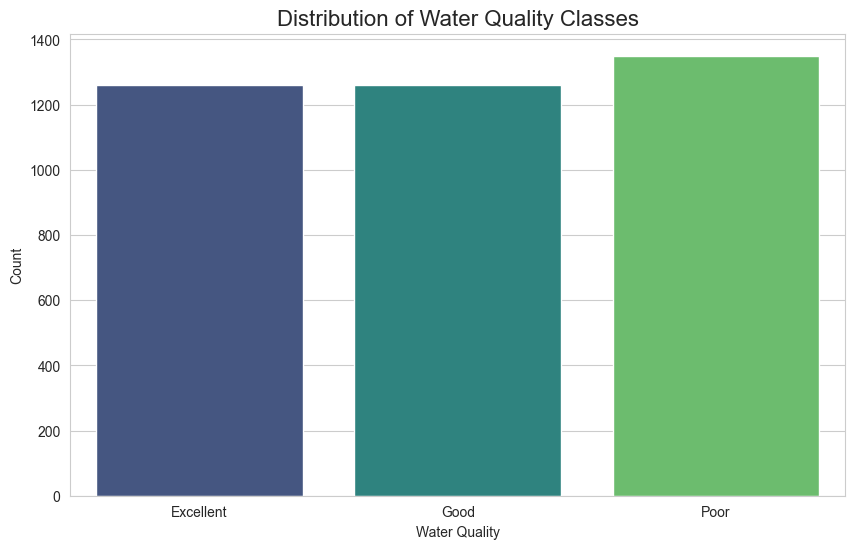

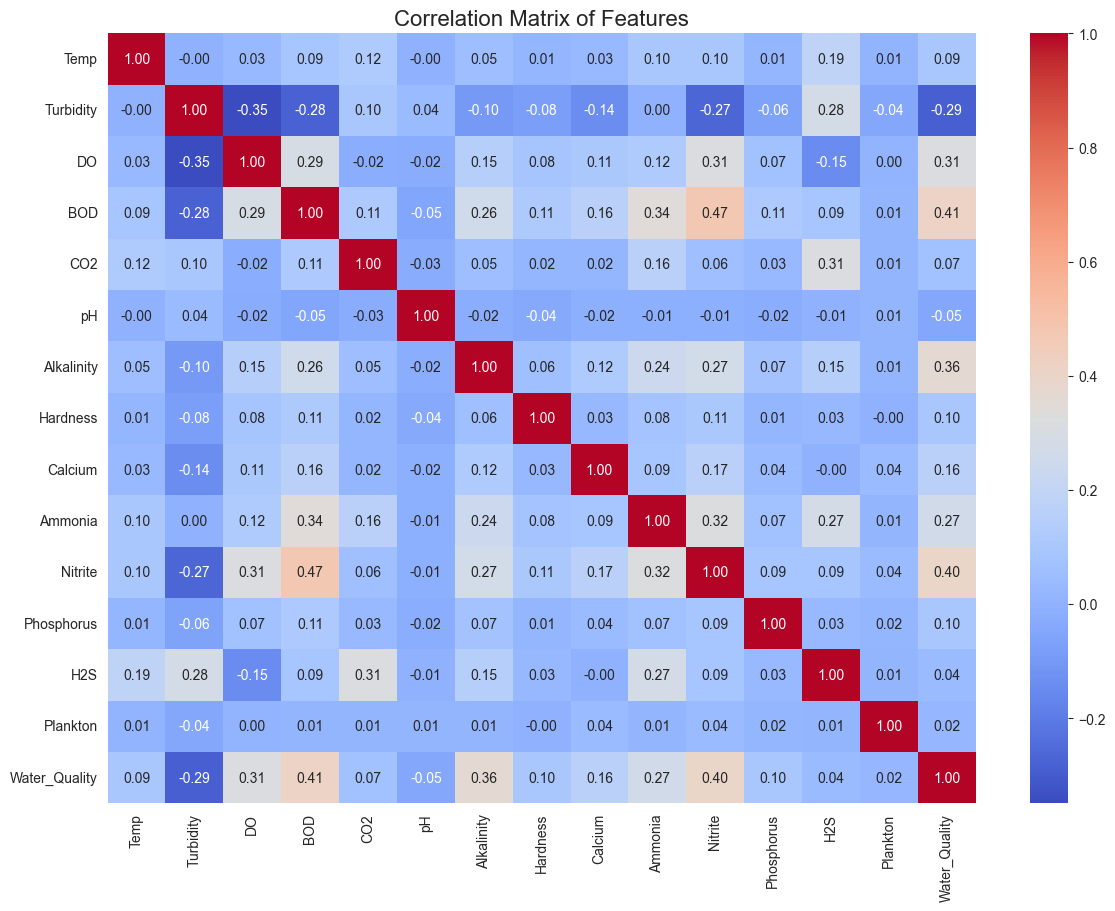

In [ ]:

plt.figure(figsize=(10, 6))
sns.countplot(x='Water_Quality_Label', data=main_df, order=['Excellent', 'Good', 'Poor'], palette='viridis')
plt.title('Distribution of Water Quality Classes', fontsize=16)
plt.xlabel('Water Quality')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(14, 10))
sns.heatmap(main_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()

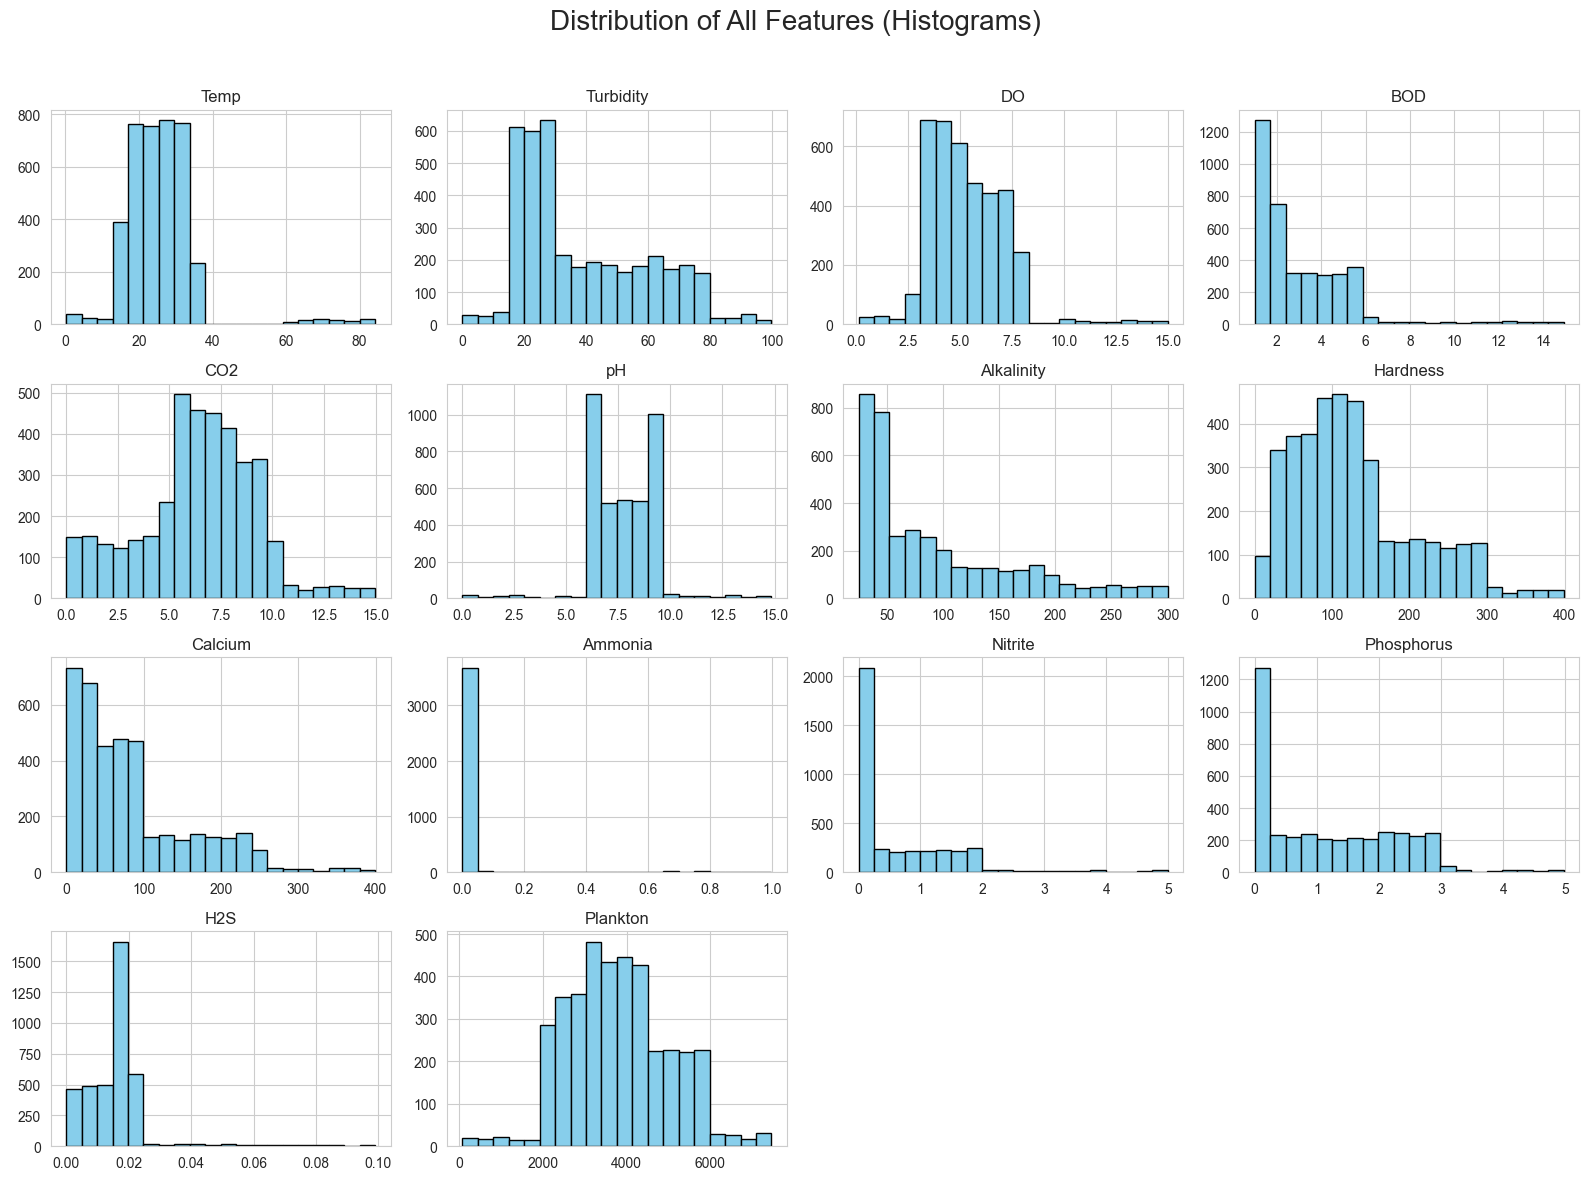

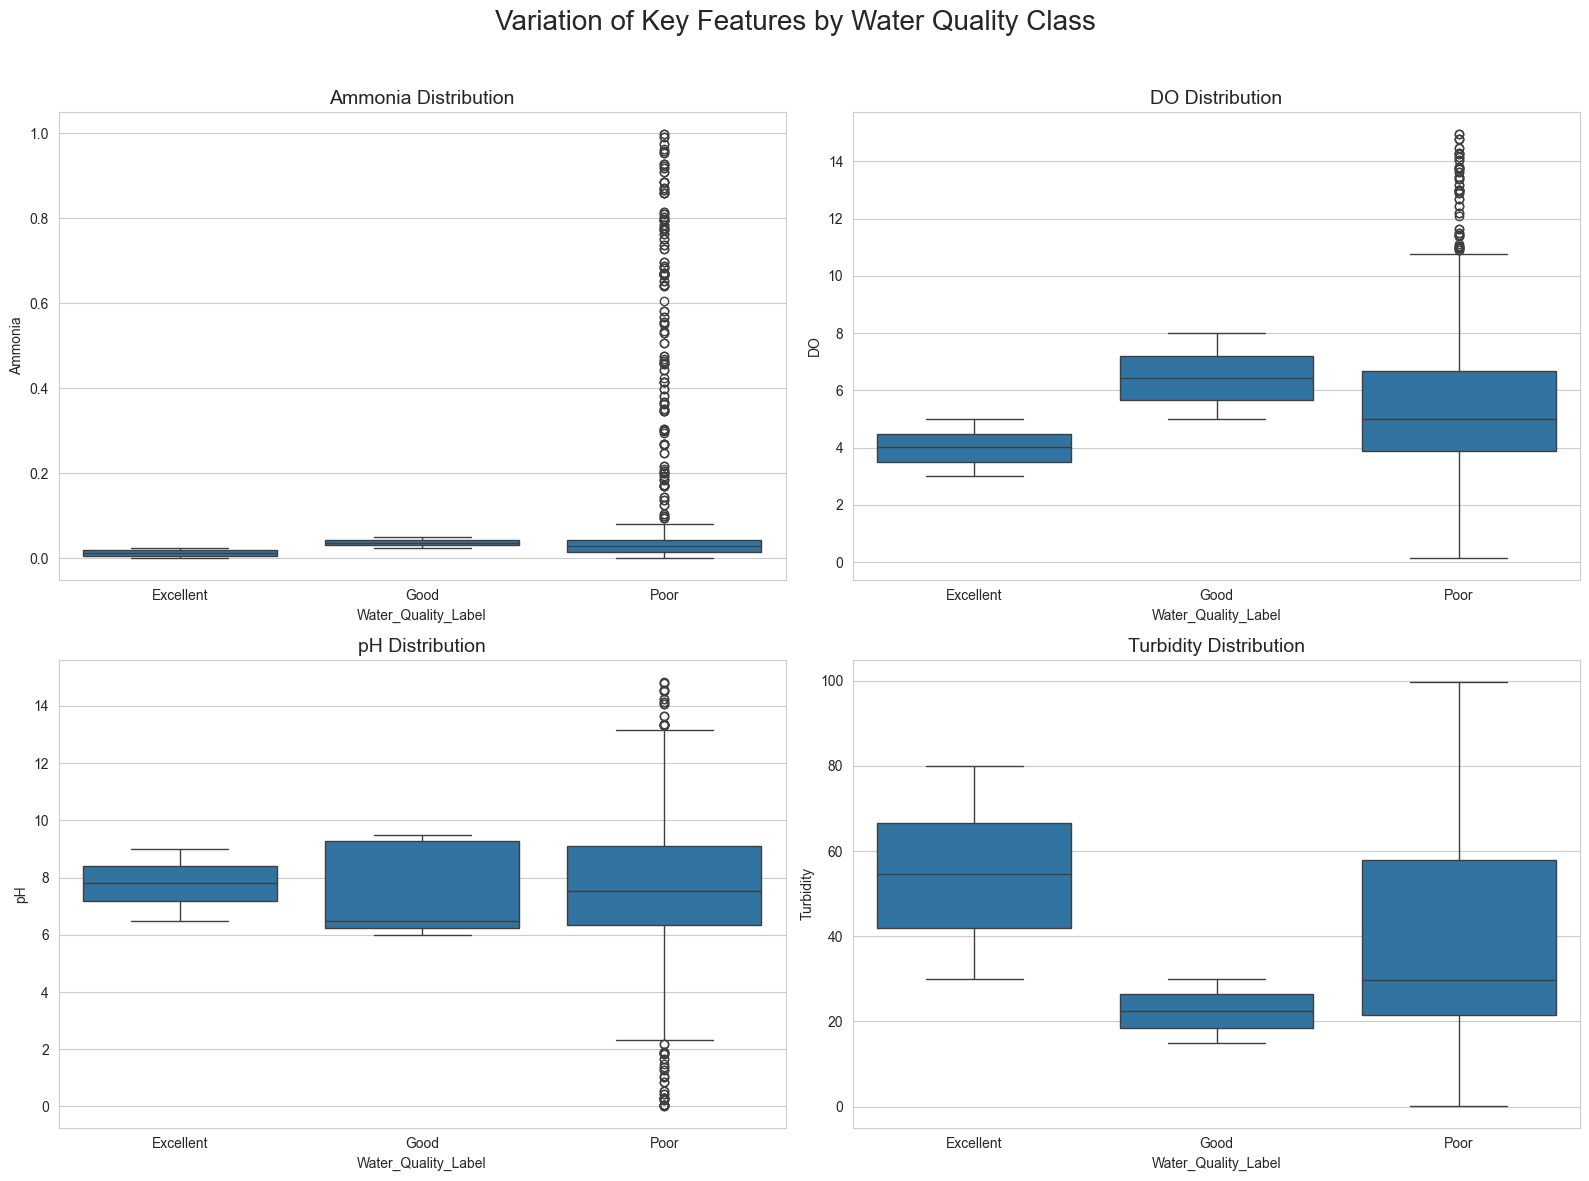

In [ ]:
# Feature Distributions and Class-Based Comparison
main_df.drop(['Water_Quality', 'Water_Quality_Label'], axis=1).hist(figsize=(16, 12), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Distribution of All Features (Histograms)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

features_to_plot = ['Ammonia', 'DO', 'pH', 'Turbidity']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Variation of Key Features by Water Quality Class', fontsize=20)
for i, feature in enumerate(features_to_plot):
    row, col = i // 2, i % 2
    sns.boxplot(x='Water_Quality_Label', y=feature, data=main_df, ax=axes[row, col], order=['Excellent', 'Good', 'Poor'])
    axes[row, col].set_title(f'{feature} Distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Data Scaling Methods 
### Description:
 Most machine learning models are negatively affected by features being on different scales.
 For example, if one feature ranges from 0-1 and another from 1000-5000, the model
 might tend to give more "weight" to the feature with larger values. We perform scaling
 to prevent this bias. The two most popular methods are:

### 1.StandardScaler:
    Transforms the data to have a mean of 0 and a standard deviation of 1.
    It is more robust to outliers and is generally the default choice.
    Formula: $$z = \frac{x - \mu}{\sigma}$$
    ($\mu$: mean, $\sigma$: standard deviation)

### 2.MinMaxScaler:
    Rescales the data to a fixed range, 0 to 1.
    The minimum value of the feature becomes 0, and the maximum value becomes 1.
    Formula: $$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$$


In [ ]:
# Data Splitting and Scaling
X = main_df.drop(['Water_Quality', 'Water_Quality_Label'], axis=1)
y = main_df['Water_Quality']

# Split the Data Set | *stratify same in both the training and the test set as it was in the original dataset 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y) #

print("Step 1: Data Set Split into Training and Test Sets")
print(f"Training set (X_train_raw) shape: {X_train_raw.shape}")
print(f"Test set (X_test_raw) shape:   {X_test_raw.shape}")
print(f"Training target (y_train) shape: {y_train.shape}")
print(f"Test target (y_test) shape:   {y_test.shape}")

#Scale the Features
print("\n Step 2: Scaling Features")
print("First 5 rows of X_train_raw BEFORE scaling:")
display(X_train_raw.head())

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)
print("\nFirst 5 rows of X_train AFTER scaling:")
display(X_train_scaled_df.head())

Step 1: Data Set Split into Training and Test Sets
Training set (X_train_raw) shape: (3096, 14)
Test set (X_test_raw) shape:   (774, 14)
Training target (y_train) shape: (3096,)
Test target (y_test) shape:   (774,)

 Step 2: Scaling Features
First 5 rows of X_train_raw BEFORE scaling:


,Temp,Turbidity,DO,BOD,CO2,pH,Alkalinity,Hardness,Calcium,Ammonia,Nitrite,Phosphorus,H2S,Plankton
1429,30.49,22.52,3.5310,5.1970,9.6900,6.4810,49.3010,98.2350,235.2570,0.0180,0.8160,0.0200,0.0150,1323.0
681,27.18,77.18,5.3750,1.7290,7.6570,12.1790,274.3750,161.4030,18.3200,0.0460,0.0020,0.0240,0.0190,3596.0
1956,16.10,26.77,7.4245,5.3997,0.6495,6.3800,194.9036,30.4815,20.7362,0.0282,0.8790,2.0749,0.0050,5675.0
329,15.42,19.28,1.3170,3.6160,3.4280,6.1210,25.5400,49.5170,16.0940,0.0450,0.5960,0.0190,0.0110,4935.0
2547,18.87,28.83,5.9955,2.9015,4.9240,9.0603,43.5963,58.1992,17.3579,0.0365,1.7726,2.8825,0.0042,2929.0



First 5 rows of X_train AFTER scaling:


,Temp,Turbidity,DO,BOD,CO2,pH,Alkalinity,Hardness,Calcium,Ammonia,Nitrite,Phosphorus,H2S,Plankton
0,0.453561,-0.790074,-0.961223,0.890609,1.174745,-0.764840,-0.640831,-0.366493,2.002872,-0.246741,0.188135,-1.065507,-0.124679,-2.020080
1,0.123075,1.856073,0.048834,-0.599489,0.459289,2.786044,2.584890,0.424742,-0.879058,-0.021873,-0.715241,-1.061819,0.204531,-0.164501
2,-0.983203,-0.584327,1.171455,0.977703,-2.006798,-0.827781,1.445920,-1.215166,-0.846960,-0.164825,0.258053,0.829044,-0.947704,1.532705
3,-1.051097,-0.946926,-2.173949,0.211299,-1.028985,-0.989185,-0.981370,-0.976730,-0.908630,-0.029904,-0.056020,-1.066429,-0.453889,0.928601
4,-0.706633,-0.484601,0.388715,-0.095700,-0.502511,0.842530,-0.722590,-0.867977,-0.891839,-0.098167,1.249769,1.573625,-1.013546,-0.709011


In [9]:
# THE CRITICAL IMPORTANCE OF SCALING & BASELINE MODELS

# SVM Performance WITHOUT Scaling
print("SVM Results with Unscaled (Raw) Data")
svm_unscaled = SVC(random_state=42).fit(X_train_raw, y_train)
y_pred_unscaled = svm_unscaled.predict(X_test_raw)
print("NOTE: These low scores obtained without scaling prove that preprocessing is vital.")
print(classification_report(y_test, y_pred_unscaled, target_names=quality_map.values()))


SVM Results with Unscaled (Raw) Data
NOTE: These low scores obtained without scaling prove that preprocessing is vital.
              precision    recall  f1-score   support

   Excellent       0.62      1.00      0.76       252
        Good       0.64      0.65      0.64       252
        Poor       0.43      0.17      0.25       270

    accuracy                           0.60       774
   macro avg       0.56      0.61      0.55       774
weighted avg       0.56      0.60      0.54       774



In [10]:
# Training Models with Default Parameters
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine (SVM)": SVC(random_state=42, probability=True),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}
print(" PERFORMANCE OF BASELINE MODELS ".center(70, "="))
for name, model in baseline_models.items():
    print(f"\n--- {name} Model (Default Settings) ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=quality_map.values()))


=================== PERFORMANCE OF BASELINE MODELS ===================

--- Logistic Regression Model (Default Settings) ---
              precision    recall  f1-score   support

   Excellent       0.88      1.00      0.93       252
        Good       0.77      0.91      0.83       252
        Poor       0.87      0.61      0.72       270

    accuracy                           0.83       774
   macro avg       0.84      0.84      0.83       774
weighted avg       0.84      0.83      0.83       774


--- Support Vector Machine (SVM) Model (Default Settings) ---
              precision    recall  f1-score   support

   Excellent       0.97      1.00      0.98       252
        Good       0.86      1.00      0.92       252
        Poor       1.00      0.81      0.90       270

    accuracy                           0.93       774
   macro avg       0.94      0.94      0.93       774
weighted avg       0.94      0.93      0.93       774


--- Random Forest Model (Default Settings) ---
  

In [ ]:
#  HYPERPARAMETER OPTIMIZATION (GRIDSEARCHCV)

# Searching for the Best Parameters with GridSearchCV 
print(" HYPERPARAMETER OPTIMIZATION STARTED ".center(70, "="))

# Search for best parameters for Random Forest
print("\nSearching for best parameters for RandomForest...")
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_leaf': [1, 2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print(f"Best RF Parameters: {grid_rf.best_params_}")

# Search for best parameters for SVM
print("\nSearching for best parameters for SVM...")
param_grid_svm = {'C': [10, 100], 'gamma': ['scale', 0.01]}
grid_svm = GridSearchCV(SVC(random_state=42, probability=True), param_grid_svm, cv=5, n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print(f"Best SVM Parameters: {grid_svm.best_params_}")

# Search for best parameters for XGBoost
print("\nSearching for best parameters for XGBoost...")
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2]}
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print(f"Best XGBoost Parameters: {grid_xgb.best_params_}")

================ HYPERPARAMETER OPTIMIZATION STARTED =================

Searching for best parameters for RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best RF Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}

Searching for best parameters for SVM...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale'}

Searching for best parameters for XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [12]:

#FINAL MODEL COMPARISON
#  Comparing Baseline and Optimized Models 
final_models = {
    "1. Random Forest (Baseline)": baseline_models["Random Forest"],
    "2. Random Forest (Optimized)": best_rf,
    "3. XGBoost (Baseline)": baseline_models["XGBoost"],
    "4. XGBoost (Optimized)": best_xgb,
    "5. SVM (Baseline)": baseline_models["Support Vector Machine (SVM)"],
    "6. SVM (Optimized)": best_svm
}
print("\n" + " COMPARING FINAL MODELS ".center(70, "="))
for name, model in final_models.items():
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=quality_map.values()))

final_best_model = best_xgb # We select the best model


======================= COMPARING FINAL MODELS =======================

--- 1. Random Forest (Baseline) ---
              precision    recall  f1-score   support

   Excellent       1.00      0.99      1.00       252
        Good       1.00      1.00      1.00       252
        Poor       0.99      1.00      0.99       270

    accuracy                           0.99       774
   macro avg       1.00      0.99      0.99       774
weighted avg       0.99      0.99      0.99       774


--- 2. Random Forest (Optimized) ---
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00       252
        Good       1.00      1.00      1.00       252
        Poor       0.99      1.00      0.99       270

    accuracy                           1.00       774
   macro avg       1.00      1.00      1.00       774
weighted avg       1.00      1.00      1.00       774


--- 3. XGBoost (Baseline) ---
              precision    recall  f1-score   support

   Ex

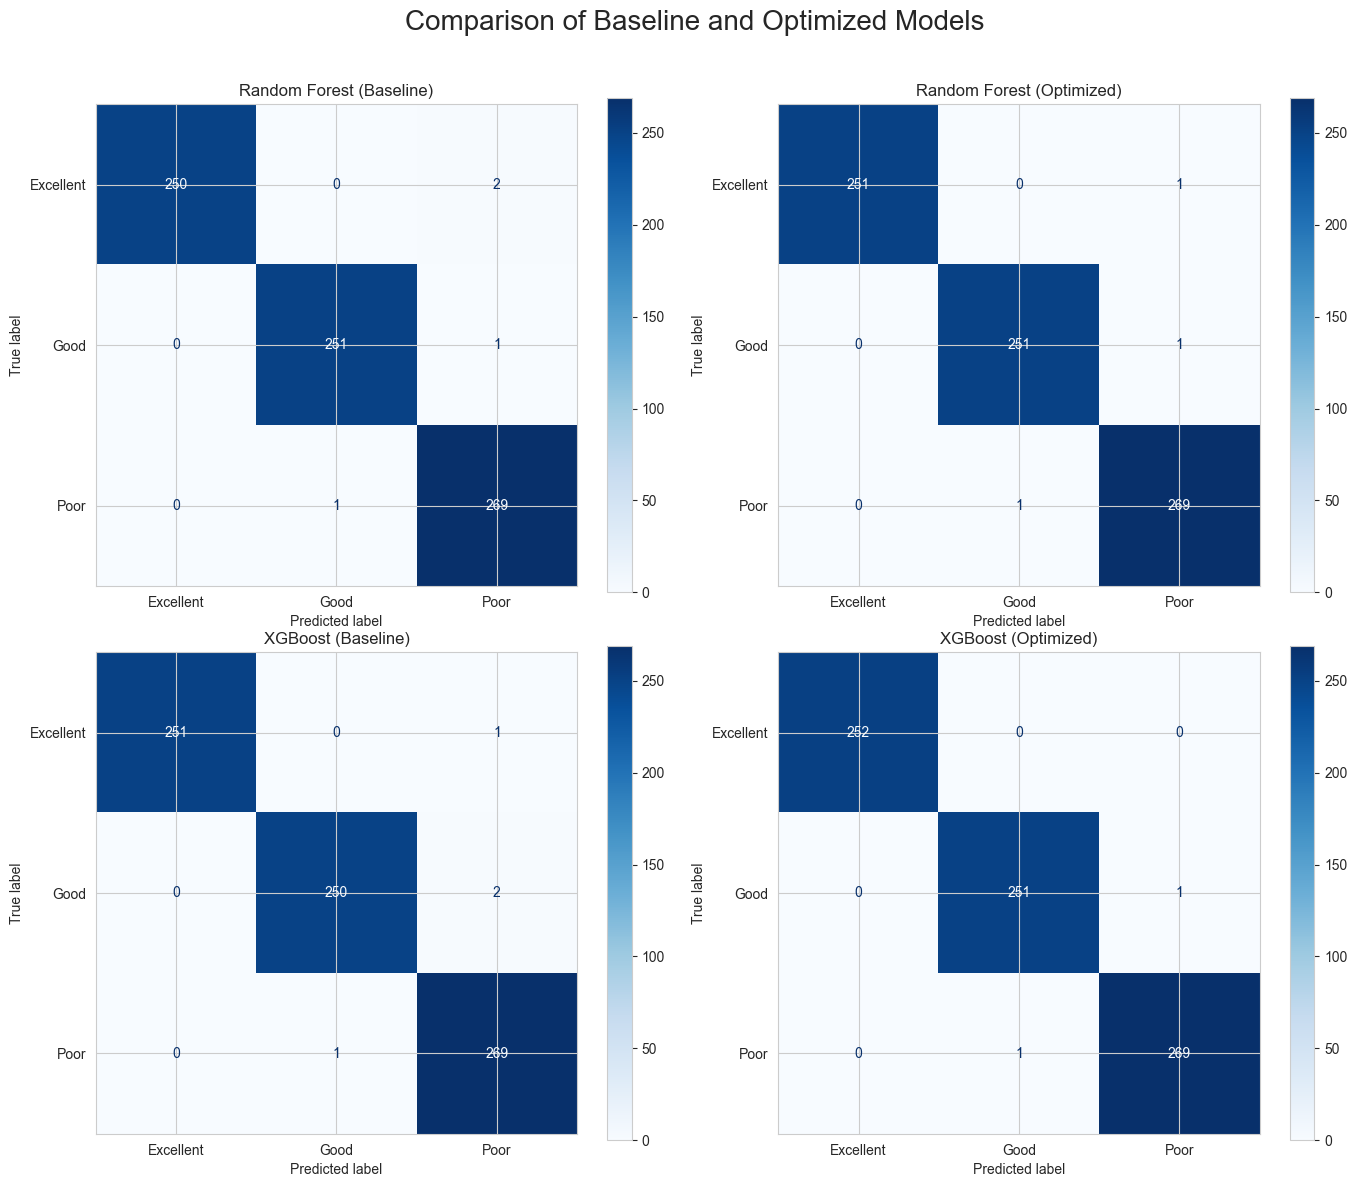

In [13]:
# Confusion Matrices for Final Models
models_to_plot = {
    "Random Forest (Baseline)": baseline_models["Random Forest"],
    "Random Forest (Optimized)": best_rf,
    "XGBoost (Baseline)": baseline_models["XGBoost"],
    "XGBoost (Optimized)": best_xgb
}
fig, axes = plt.subplots(2, 2, figsize=(14, 12)); fig.suptitle('Comparison of Baseline and Optimized Models', fontsize=20); axes = axes.flatten()
for i, (name, model) in enumerate(models_to_plot.items()):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=quality_map.values(), cmap=plt.cm.Blues, ax=axes[i]); axes[i].set_title(name)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

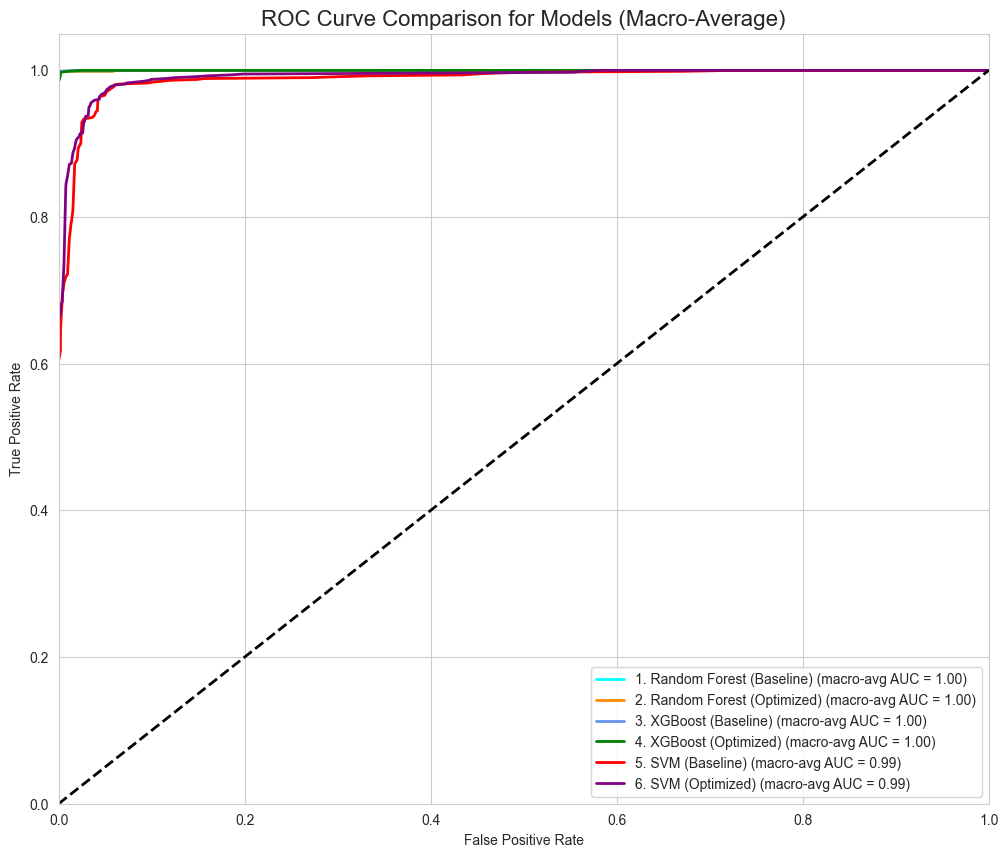

In [ ]:
# ROC Curve and AUC Score 
# Description: The ROC Curve shows how well a model can distinguish between classes.
# The closer the Area Under the Curve (AUC) is to 1, the more successful the model.

# Binarize the output for multiclass ROC analysis
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for (name, model), color in zip(final_models.items(), colors):
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):#linear interpolation
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"], color=color, lw=2,
             label=f'{name} (macro-avg AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Models (Macro-Average)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Interpreting the Best Model (XGBoost) with SHAP

SHAP Values Calculated. Summary Plot:


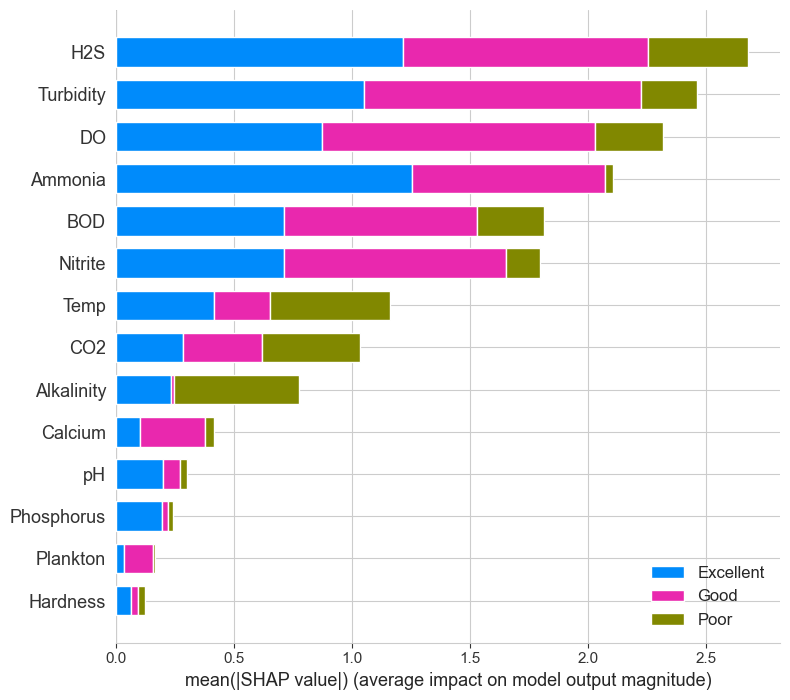


--- Prediction Explanation for the First Test Sample ---
Model prediction: Excellent, Actual value: Excellent


In [ ]:
#  MODEL INTERPRETABILITY (SHAP)

# Description: SHAP is a modern method that shows how much and in what direction
# each feature affects a model's prediction.
print("Interpreting the Best Model (XGBoost) with SHAP")
explainer = shap.TreeExplainer(final_best_model)
# Create a modern SHAP Explanation object, which is easier and safer to work with
shap_explanation = explainer(pd.DataFrame(X_test, columns=X.columns))

print("\nSHAP Values Calculated. Summary Plot:")
# Global Feature Importance
# The summary_plot works directly with the new explanation object
shap.summary_plot(shap_explanation, plot_type="bar", class_names=list(quality_map.values()))

# --- Explanation of a single prediction (the first test sample) ---
print("\n--- Prediction Explanation for the First Test Sample ---")
true_label_index = y_test.iloc[0]
predicted_label_index = final_best_model.predict(X_test[0:1])[0]

print(f"Model prediction: {quality_map[predicted_label_index]}, Actual value: {quality_map[true_label_index]}")
shap.initjs()

# We will create a plot explaining the model's reasoning for the 'Excellent' class (index 0) for the first sample.
shap.force_plot(shap_explanation[0, :, 0])

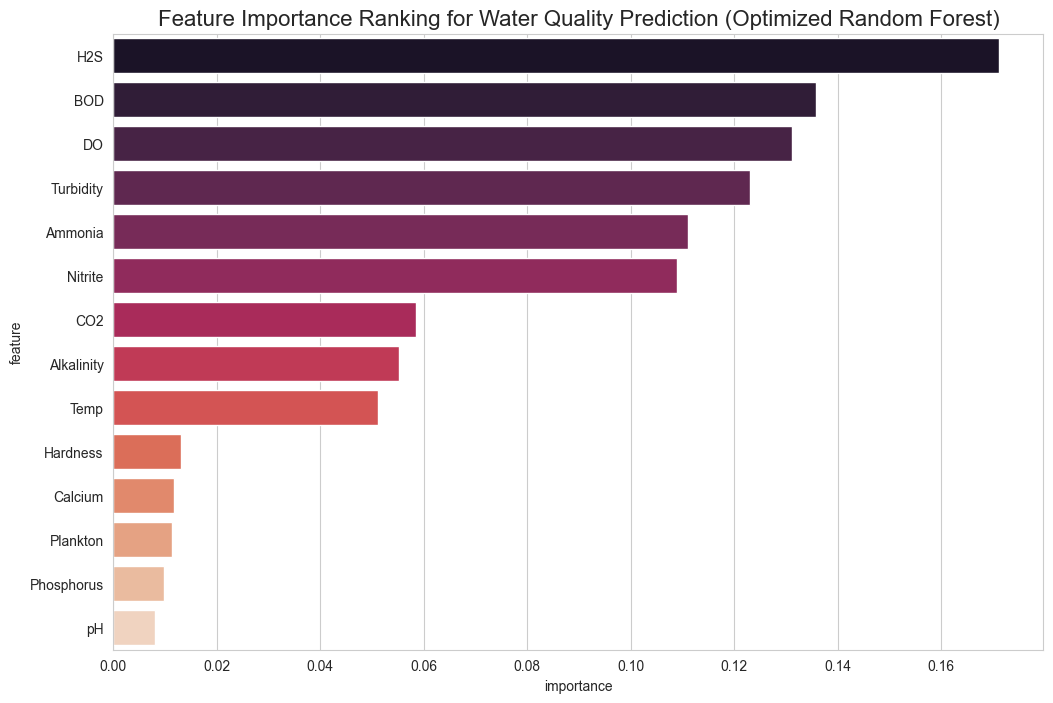

In [37]:

# FINAL INTERPRETATION - FEATURE IMPORTANCE

# Feature Importance Ranking According to the Best Model 

best_model_for_importance = best_rf # Using the optimized RF model
importances = best_model_for_importance.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='rocket')
plt.title('Feature Importance Ranking for Water Quality Prediction (Optimized Random Forest)', fontsize=16)
plt.show()

In [ ]:

#SAVING AND LOADING THE MODEL
# Saving the Best Model and Scaler

model_file = 'models/water_quality_xgb_model.joblib'
scaler_file = 'models/water_quality_scaler.joblib'

joblib.dump(final_best_model, model_file)
joblib.dump(scaler, scaler_file)
print(f"Best model saved as '{model_file}'.")
print(f"Scaler object saved as '{scaler_file}'.")

Best model saved as 'models/water_quality_xgb_model.joblib'.
Scaler object saved as 'models/water_quality_scaler.joblib'.


In [39]:
# Loading the Saved Model 
loaded_model = joblib.load(model_file)
loaded_scaler = joblib.load(scaler_file)
print("\nModel and Scaler successfully loaded from disk.")
print("Loaded model:", loaded_model)


Model and Scaler successfully loaded from disk.
Loaded model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


In [ ]:

# LIVE PREDICTION (INFERENCE)

# Selecting Samples from the Inference Set and Predicting ---
sample_to_predict = inference_df.sample(3, random_state=73)
X_predict = sample_to_predict.drop(['Water_Quality', 'Water_Quality_Label'], axis=1)
y_true = sample_to_predict['Water_Quality']

print("3 Samples Selected for Live Prediction"); display(sample_to_predict)

# Use the loaded scaler and model
X_predict_scaled = loaded_scaler.transform(X_predict)
print("\nSelected Samples Scaled for the Model"); display(pd.DataFrame(X_predict_scaled, columns=X.columns))

predictions = loaded_model.predict(X_predict_scaled)
prediction_labels = [quality_map[p] for p in predictions]
results = pd.DataFrame({'Actual Value': y_true.map(quality_map).values, 'Model Prediction': prediction_labels})
results['Result'] = np.where(results['Actual Value'] == results['Model Prediction'], '✅ CORRECT', '❌ INCORRECT')

print("\n" + " LIVE PREDICTION RESULTS ".center(70, "=")); display(results)

--- 3 Samples Selected for Live Prediction ---


,Temp,Turbidity,DO,BOD,CO2,pH,Alkalinity,Hardness,Calcium,Ammonia,Nitrite,Phosphorus,H2S,Plankton,Water_Quality,Water_Quality_Label
2816,31.34,15.08,6.6856,3.3045,0.2433,9.4993,111.8148,57.7851,16.3144,0.0256,0.6636,2.3084,0.0069,5102.0,1,Good
1021,20.40,56.82,6.7940,1.6400,5.1570,6.8370,138.8290,235.8630,96.2620,0.4240,0.1360,2.9860,0.0190,3533.0,2,Poor
2315,31.31,19.65,7.5408,4.5604,9.2377,6.0487,37.5094,156.8616,121.8674,0.0429,1.4427,2.7732,0.0090,2584.0,1,Good



--- Selected Samples Scaled for the Model ---


,Temp,Turbidity,DO,BOD,CO2,pH,Alkalinity,Hardness,Calcium,Ammonia,Nitrite,Phosphorus,H2S,Plankton
0,0.538429,-1.150252,0.766720,0.077457,-2.149748,1.116106,0.255106,-0.873164,-0.905702,-0.185705,0.019002,1.044323,-0.791329,1.064932
1,-0.553871,0.870424,0.826096,-0.637730,-0.420513,-0.542988,0.642268,1.357420,0.156373,3.013845,-0.566528,1.669049,0.204531,-0.215931
2,0.535433,-0.929014,1.235158,0.617081,1.015571,-1.034241,-0.809826,0.367857,0.496532,-0.046769,0.883646,1.472854,-0.618494,-0.990654



====================== LIVE PREDICTION RESULTS =======================


,Actual Value,Model Prediction,Result
0,Good,Good,✅ CORRECT
1,Poor,Poor,✅ CORRECT
2,Good,Good,✅ CORRECT


Can we build a simpler, faster, and cheaper model by focusing only on what truly matters?'

* So, I encourage you to try this as an exercise. The steps are simple:

* Take the original training and test sets. 

* Filter them to keep only the top 6 most important features we identified.

* Re-scale this new, smaller dataset .

* And finally, re-train the baseline models.